In [1]:
%matplotlib inline

import pandas_datareader.data as web
import datetime as datetime
import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.signal import lfilter

orig_df = web.DataReader('JPNRGDPEXP', 'fred' ,start = datetime.datetime(1994,1,1),end = datetime.datetime(2021,1,1))

In [2]:
# transform data
orig_df = orig_df.dropna(how='any')
index = pd.date_range(orig_df.index[0], periods=orig_df.shape[0], freq="QS")
orig_df.set_index(index, inplace=True)

# take log
df = np.log(orig_df)
df

,JPNRGDPEXP
1994-01-01,13.008699
1994-04-01,13.003142
1994-07-01,13.014642
1994-10-01,13.010609
1995-01-01,13.021622
...,...
2020-01-01,13.207129
2020-04-01,13.122828
2020-07-01,13.174381
2020-10-01,13.202121


In [3]:
# model parameters
nobs = len(df)
phi_vec = np.r_[0.5, 0.5] #phi1, phi2
sigma_sq = np.r_[10, 10, 10] #sigma_tau, sigma_c, sigma_beta

In [4]:
"""
Univariate Local Linear Trend Model
"""
class LocalLinearTrend(sm.tsa.statespace.MLEModel):
    def __init__(self, endog):
        # Model order
        k_states = 4
        k_posdef = 4

        # Initialize the statespace
        super(LocalLinearTrend, self).__init__(
            endog, k_states=k_states, k_posdef=k_posdef,
            initialization='approximate_diffuse',
            loglikelihood_burn=k_states
        )

        # Initialize the matrices
        self.ssm['design'] = np.array([1, 1, 0, 0])
        self.ssm['transition'] = np.array([[1, 0, 1, 0],
                                       [0, phi_vec[0], 0, phi_vec[1]],
                                       [0, 0, 1, 0],
                                       [0, 1, 0, 0]])
        self.ssm['selection'] = np.eye(k_states)
        self.ssm['selection', 3, 3] = 0

        # Cache some indices
        self._state_cov_idx = ('state_cov',) + np.diag_indices(k_posdef)

    @property
    def param_names(self):
        return ['phi.1', 'phi.2', 'sigma2.tau', 'sigma2.c', 'sigma2.beta']

    @property
    def start_params(self):
        return [phi_vec[0], phi_vec[1], sigma_sq[0], sigma_sq[1], sigma_sq[2]]

    def transform_params(self, unconstrained):
        # only variance 
        unconstrained[2:] = unconstrained[2:]**2
        return unconstrained

    def untransform_params(self, constrained):
        # only variance
        constrained[2:] = constrained[2:]**0.5
        return constrained

    def update(self, params, *args, **kwargs):
        params = super(LocalLinearTrend, self).update(params, *args, **kwargs)
        self['transition', 1, 1] = params[0]
        self['transition', 1, 3] = params[1]
        self['state_cov', 0, 0] = params[2]
        self['state_cov', 1, 1] = params[3]
        self['state_cov', 2, 2] = params[4]

In [5]:
# Create and fit the model
mod = LocalLinearTrend(df)
res = mod.fit(disp=False)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:             JPNRGDPEXP   No. Observations:                  109
Model:               LocalLinearTrend   Log Likelihood                 297.090
Date:                Tue, 20 Jul 2021   AIC                           -584.179
Time:                        04:59:26   BIC                           -570.909
Sample:                    01-01-1994   HQIC                          -578.802
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
phi.1           0.7277      0.292      2.493      0.013       0.156       1.300
phi.2          -0.0243      0.146     -0.166      0.868      -0.310       0.262
sigma2.tau    6.79e-05      0.000      0.503      0.615      -0.000       0.000
sigma2.c        0.0001      0.000      0.817      0.414      -0.000       0.000
sigma2.beta  8.595e-13   2.05e-07   4.19e-06      1.000   -4.03e-07    4.03e-07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1368.24
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               6.59   Skew:                            -2.88
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [6]:
trend = res.states.smoothed['state.0']
trend

1994-01-01    13.038139
1994-04-01    13.039624
1994-07-01    13.041006
1994-10-01    13.038338
1995-01-01    13.041539
                ...    
2020-01-01    13.204811
2020-04-01    13.176015
2020-07-01    13.191987
2020-10-01    13.200596
2021-01-01    13.197560
Freq: QS-JAN, Name: state.0, Length: 109, dtype: float64

In [7]:
cycle = res.states.smoothed['state.1']
cycle

1994-01-01   -0.029440
1994-04-01   -0.036482
1994-07-01   -0.026365
1994-10-01   -0.027729
1995-01-01   -0.019917
                ...   
2020-01-01    0.002318
2020-04-01   -0.053187
2020-07-01   -0.017606
2020-10-01    0.001524
2021-01-01   -0.005503
Freq: QS-JAN, Name: state.1, Length: 109, dtype: float64

In [8]:
# plot data function
def plot_data(data_b, data_r, label, title, ax_label=None):
    
    plt.figure(figsize=(8, 5))
    
    # plot
    if data_b is not None:
        plt.plot(data_b.index, data_b, label=label[0], color="blue")
    if data_r is not None:
        plt.plot(data_r.index, data_r, label=label[1], color="darkorange")
    
    # title
    plt.title(title)
    
    # axis label
    if ax_label is not None:
        plt.xlabel(ax_label[0])   
        plt.ylabel(ax_label[1])
    
    #setting
    plt.xticks(rotation=90, size='small')
    
    # display
    plt.legend()

    # show
    plt.show()

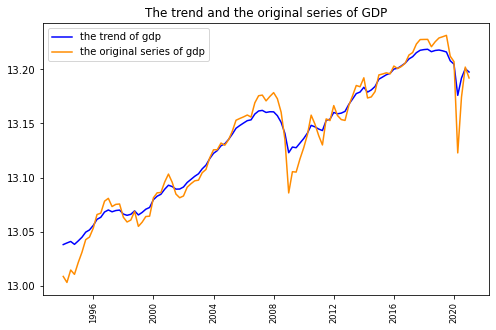

In [9]:
# plot trend
plot_data(trend, df,  ['the trend of gdp', 'the original series of gdp'], 'The trend and the original series of GDP')

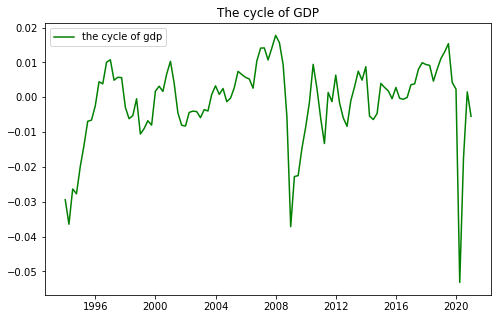

In [10]:
plt.figure(figsize=(8, 5))

# plot cycle
plt.plot(cycle.index, cycle, label="the cycle of gdp", color="green")

# title
plt.title("The cycle of GDP")

plt.legend()

# show
plt.show()